This is a start I will clean it up
TO DO

1. Load all the modules
2. read the training pool 
3. select random training set of 25 structure from the pool (can be done with np.rand) --> latter exclude these from the pool
4. Train a committee (just to check we can train 2)
5. predict on the training pool and sort max energy error
6. Then we repeat in a for loop.

## To Do 

- for loop everywhere
- avoid using scripts for MACE
- fix E0s

## Import modules

In [52]:
import os, sys
import warnings
import logging
import numpy as np
import matplotlib.pyplot as plt
from ase.io import read, write
from mace.cli.run_train import main as mace_run_train_main
from mace.cli.eval_configs import main as mace_eval_configs_main

## Select initial training structures

In [12]:
zundel_pool = read('../initial-datasets/zundel/train.extxyz', index=':')
# zundel_pool

In [42]:
warnings.filterwarnings("ignore")

def extxyz2energy(file,keyword="MACE_energy"):
    """
    Convert extxyz file to numpy array
    """
    atoms = read(file, index=':')
    data = [None]*len(atoms)
    for n,atom in enumerate(atoms):
        data[n] = atom.info[keyword]
    return np.array(data)

def train_mace(config_file_path):
    logging.getLogger().handlers.clear()
    sys.argv = ["program", "--config", config_file_path]
    mace_run_train_main()
    
def eval_mace(model,infile,outfile):
    logging.getLogger().handlers.clear()
    sys.argv = ["program", "--config", infile,"--output",outfile,"--model",model]
    mace_eval_configs_main()

In [84]:
print(f'Total number of structures in pool {len(zundel_pool)}')

np.random.seed(0)
selected_indices = np.random.choice(len(zundel_pool), size=50, replace=False)
remaining_candidate_idcs = np.delete(np.arange(len(zundel_pool)), selected_indices)
print(f'Selected indices: {selected_indices}')
initial_training_set = [zundel_pool[i] for i in selected_indices]

# Save the selected structures to a new file
write('initial_training_set.extxyz', initial_training_set[:25], format='extxyz')
write('initial_test_set.extxyz', initial_training_set[25:], format='extxyz')


Total number of structures in pool 10001
Selected indices: [9395  898 2398 4737 2343 5111 5507 6452 2670 3188 1087 1819 2308 6085
 3725 8704 7052 8563 2702 6782 2931 8754 8229 4463 3032 3214 3018  382
 4238 7693 4269 3192 7842 8057 9367 5335 8865 9033  580 9038 6078 8232
 7677 4220 8776 9911 4612 5300 5603 3481]


## Hyperparameters

Hyperparameters for the committee members

In [25]:
os.makedirs('config', exist_ok=True)
os.makedirs('models', exist_ok=True)
os.makedirs('log', exist_ok=True)
os.makedirs('chk', exist_ok=True)
os.makedirs('results', exist_ok=True)


In [48]:
%%writefile config/config-01.yml

model: "MACE"
num_channels: 32
max_L: 0
r_max: 4.0
name: "mace_com1"
model_dir: "MACE_models"
log_dir: "MACE_models"
checkpoints_dir: "MACE_models"
results_dir: "MACE_models"
train_file: "initial_training_set.extxyz"
energy_key: "REF_energy"
forces_key: "REF_forces"
E0s: "average"
device: cpu
batch_size: 2
max_num_epochs: 20
swa: True
seed: 1

Overwriting config/config-01.yml


In [30]:
%%writefile config/config-02.yml

model: "MACE"
num_channels: 32
max_L: 0
r_max: 4.0
name: "mace_com2"
model_dir: "MACE_models"
log_dir: "MACE_models"
checkpoints_dir: "MACE_models"
results_dir: "MACE_models"
train_file: "initial_training_set.extxyz"
energy_key: "REF_energy"
forces_key: "REF_forces"
E0s: "average"
device: cpu
batch_size: 2
max_num_epochs: 20
swa: True
seed: 2

Overwriting config/config-02.yml


In [49]:
train_mace("config/config-01.yml")
# train_mace("config/config-02.yml")

2025-05-15 10:43:01.329 INFO: ===========VERIFYING SETTINGS===========
2025-05-15 10:43:01.330 INFO: MACE version: 0.3.10
2025-05-15 10:43:01.331 INFO: Using CPU
2025-05-15 10:43:01.367 INFO: ===========LOADING INPUT DATA===========
2025-05-15 10:43:01.368 INFO: Using heads: ['default']
2025-05-15 10:43:01.369 INFO: =============    Processing head default     ===========
2025-05-15 10:43:01.384 INFO: Training file 1/1 [25 configs, 25 energy, 25 forces, 25 stresses] loaded from 'initial_training_set.extxyz'
2025-05-15 10:43:01.385 INFO: Total training set [25 configs, 25 energy, 25 forces, 25 stresses]
2025-05-15 10:43:01.386 INFO: Using random 10% of training set for validation with following indices: [6, 19]
2025-05-15 10:43:01.386 INFO: Validation set contains 2 configurations [2 energy, 2 forces, 2 stresses]
2025-05-15 10:43:01.387 INFO: Total number of configurations: train=23, valid=2, tests=[],
2025-05-15 10:43:01.387 WARNING: Validation batch size (10) is larger than the number

In [53]:
# eval_mace("MACE_models/mace_com1_stagetwo_compiled.model",'../initial-datasets/zundel/train.extxyz',"eval_train_01.extxyz") # 50s
eval_mace("MACE_models/mace_com2_stagetwo_compiled.model",'../initial-datasets/zundel/train.extxyz',"eval_train_02.extxyz")

INFO:root:Using CPU


In [54]:
E1 = extxyz2energy("eval_train_01.extxyz")
E2 = extxyz2energy("eval_train_02.extxyz")

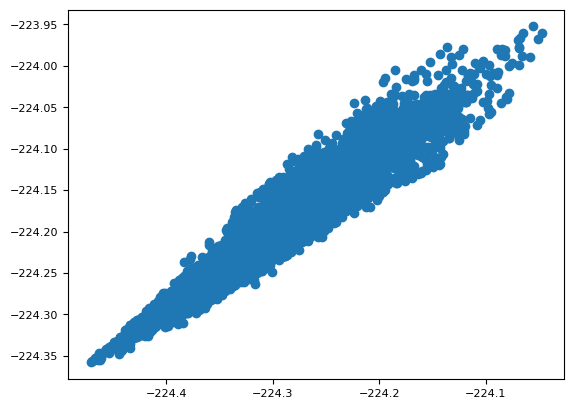

In [ ]:
plt.scatter(E1,E2)

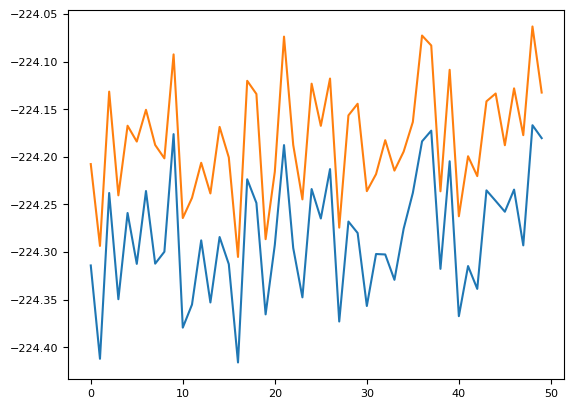

In [59]:
plt.plot(E1[selected_indices], label='MACE 1')
plt.plot(E2[selected_indices], label='MACE 2')

In [66]:
E = np.array([E1,E2]).T
mean = np.mean(E, axis=1) # mean of each structure
std = np.std(E, axis=1) # std of each structure

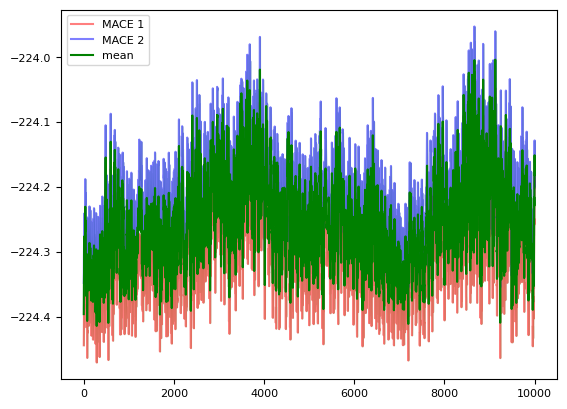

In [ ]:
plt.plot(E1, label='MACE 1',color='red',alpha=0.5)
plt.plot(E2, label='MACE 2',color='blue',alpha=0.5)
plt.plot(mean, label='mean',color='green')
# plt.fill_between(range(len(mean)), mean-std, mean+std, color='green', alpha=0.2)
plt.legend()

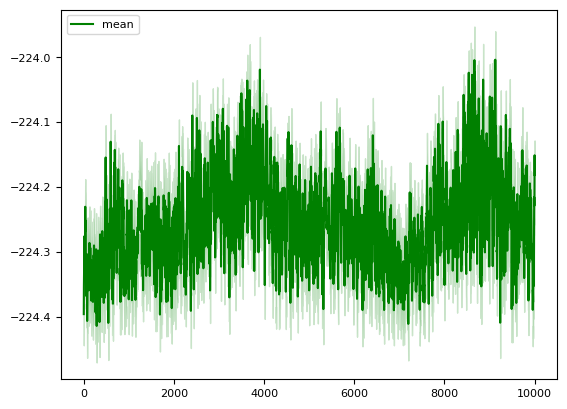

In [72]:
plt.plot(mean, label='mean',color='green')
plt.fill_between(range(len(mean)), mean-std, mean+std, color='green', alpha=0.2)
plt.legend()

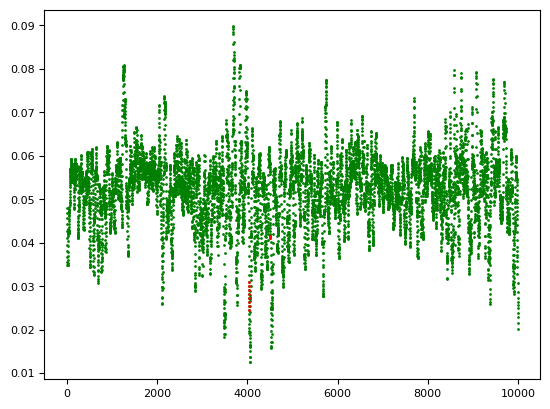

In [98]:
# Fix this
new_candidates = np.argsort(std[remaining_candidate_idcs])[:10]
plt.scatter(np.arange(len(std)),std, label='mean',color='green',s=1)
plt.scatter(new_candidates,std[new_candidates],color="red",s=1)

10001

(9951,)